<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Let's-set-up-some-common-file-paths" data-toc-modified-id="Let's-set-up-some-common-file-paths-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Let's set up some common file paths</a></span></li></ul></li><li><span><a href="#Behavior" data-toc-modified-id="Behavior-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Behavior</a></span><ul class="toc-item"><li><span><a href="#Extract-sync-time-stamps" data-toc-modified-id="Extract-sync-time-stamps-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extract sync time stamps</a></span></li><li><span><a href="#Extract-some-trial-features-so-we-can-analyze-all-of-this-neural-data..." data-toc-modified-id="Extract-some-trial-features-so-we-can-analyze-all-of-this-neural-data...-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract some trial features so we can analyze all of this neural data...</a></span></li></ul></li><li><span><a href="#Spikes" data-toc-modified-id="Spikes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spikes</a></span><ul class="toc-item"><li><span><a href="#Turn-spike-times-into-trains-and-firing-rates" data-toc-modified-id="Turn-spike-times-into-trains-and-firing-rates-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Turn spike times into trains and firing rates</a></span></li><li><span><a href="#Chop-1-kHz-spike-data-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior" data-toc-modified-id="Chop-1-kHz-spike-data-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Chop 1 kHz spike data into trials and downsample, aligned to event timestamps extracted from behavior</a></span></li></ul></li><li><span><a href="#LFP" data-toc-modified-id="LFP-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LFP</a></span><ul class="toc-item"><li><span><a href="#Bandpass-and-smooth-LFP-in-standard-frequency-windows,-and-align-to-sync-points-(leave-at-1-kHz)" data-toc-modified-id="Bandpass-and-smooth-LFP-in-standard-frequency-windows,-and-align-to-sync-points-(leave-at-1-kHz)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Bandpass and smooth LFP in standard frequency windows, and align to sync points (leave at 1 kHz)</a></span></li><li><span><a href="#Downsample-chopped-LFP" data-toc-modified-id="Downsample-chopped-LFP-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Downsample chopped LFP</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Let's-check-out-spikes-synced-to-the-start-of-the-trial" data-toc-modified-id="Let's-check-out-spikes-synced-to-the-start-of-the-trial-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Let's check out spikes synced to the start of the trial</a></span></li><li><span><a href="#Let's-check-out-some-LFP-magnitudes-and-phases-synced-to-the-start-of-the-trial" data-toc-modified-id="Let's-check-out-some-LFP-magnitudes-and-phases-synced-to-the-start-of-the-trial-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Let's check out some LFP magnitudes and phases synced to the start of the trial</a></span></li></ul></li></ul></div>

Skeleton for final project...

# Setup

## Let's set up some common file paths

In [1]:
%%writefile process_behavior.py
import mat73
import h5py

from collections import defaultdict

import numpy as np
import pandas as pd

import scipy.signal as signal
import scipy.ndimage as ndimage
import scipy.stats as stats

# import dask.array as da


Overwriting process_behavior.py


In [2]:
%%writefile process_neural.py
import mat73
import h5py

from collections import defaultdict

import numpy as np
import pandas as pd

import scipy.signal as signal
import scipy.ndimage as ndimage
import scipy.stats as stats
# import dask.array as da

Overwriting process_neural.py


In [3]:
from os.path import join as pjoin
import glob
import matplotlib.pyplot as plt
from importlib import reload

data_dir = "data_clean"
session = "George00_rec14_01282021"

bhv_fnames = sorted(glob.glob(pjoin(data_dir, session + "*bhv*"))) # could be >1
spk_fname = glob.glob(pjoin(data_dir, session + "*units*"))[0] # expect 1
lfp_fname = glob.glob(pjoin(data_dir, session + "*LFP*"))[0] # expect 1

In [4]:
# to save time for the demo, let's restrict everthing to a few exciting channels:

fun_channels = [107, 110, 112]

# Behavior

## Extract sync time stamps

For each session, we want to pull out snippets around task events. Two standard sync points are the start (pictures are displayed on the screen) and end (animal makes a selection with a lever movement) of each trial. This function could be customized easily-- we just need a vector of time stamps (in seconds) to align the neural data.

In [5]:
%%writefile -a process_behavior.py
def load_raw_bhv(bhv_fnames):
    """
    Load raw bhv (.bhv2 saved as .mat) into dict; consolidate 
    if split across multiple files (assume alpha order)
    
    Parameters:
    ----------
    bhv_fnames : list 
        File path(s) for behavior data
        
    Returns:
    -------
    bhv_data : dict
        All task data
        
    """
    
    bhv_data = defaultdict(list)
    
    for f in bhv_fnames:
        print(f)
        data = mat73.loadmat(f)

        data_vars = data["bhvdata"].keys()
        for v in data_vars:
            bhv_data[v] += data["bhvdata"][v]
            
    return bhv_data

def load_pl2_codes(spk_fname):
    """
    Load task event codes and corresponding time stamps from 
    raw spk (.pl2 saved as .mat).
    
    Parameters:
    ----------
    spk_fname : string
        File path for spk data
    
    Returns:
    -------
    pl2_codes : dict
        Event codes and timestamps from whole session
    
    """
    
    pl2_codes = mat73.loadmat(spk_fname, \
                              only_include=["event_codes", "event_ts"])
    
    return pl2_codes


Appending to process_behavior.py


In [6]:
%%writefile -a process_behavior.py
def get_trial_events(bhv_data, pl2_codes, event):
    """
    For each trial in bhv_data, pull time for this event code 
    (-1 if doesn't exist)
    
    Parameters:
    ----------
    bhv_data : dict
        All task data
    pl2_codes : dict
        Event codes and timestamps from whole session
    event : int
        Event code word
    
    Returns:
    -------
    timestamps : np vector
        Timestamps corresponding to event within each trial (or -1)
        
    """
    
    # cut up trials by default start and stop codes
    start_code = 9
    stop_code = 18
    
    trial_start = np.where(pl2_codes["event_codes"] == start_code)[0]
    trial_stop = np.where(pl2_codes["event_codes"] == stop_code)[0]
    
    # check that we have the same number of trials from bhv and pl2 data
    ntr = len(bhv_data["Trial"])
    if trial_start.shape[0] != ntr or trial_stop.shape[0] != ntr:
        raise ValueError("oops! mismatched bhv2 and pl2 trial counts")
    
    # cycle through all trials, save event time (if exists)
    timestamps = -1 * np.ones(ntr)
    for tr in range(ntr):
        
        # restrict to event codes in this trial
        codes = pl2_codes["event_codes"][trial_start[tr] : trial_stop[tr]]
        ts = pl2_codes["event_ts"][trial_start[tr] : trial_stop[tr]]
        
        idx = np.where(codes == event)[0]
        if idx.shape[0] == 1:
            timestamps[tr] = ts[idx]
    
    return timestamps
    

Appending to process_behavior.py


In [7]:
from process_behavior import *
# load bhv data for this session
bhv_data = load_raw_bhv(bhv_fnames)

data_clean/George00_rec14_01282021-bhv_A.mat
data_clean/George00_rec14_01282021-bhv_B.mat
data_clean/George00_rec14_01282021-bhv_C.mat


In [8]:
# load spk events for this session
pl2_codes = load_pl2_codes(spk_fname)

(array([863.,  77.,  70.,  70.,  75.,  67.,  52.,  51.,  49.,  43.]),
 array([-1.00000000e+00,  7.05580460e+02,  1.41216092e+03,  2.11874138e+03,
         2.82532184e+03,  3.53190230e+03,  4.23848276e+03,  4.94506322e+03,
         5.65164368e+03,  6.35822414e+03,  7.06480460e+03]),
 <BarContainer object of 10 artists>)

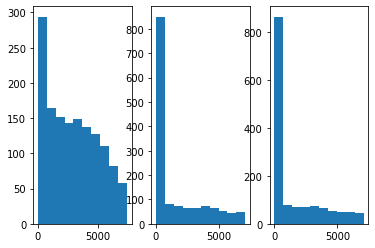

In [9]:
# get time stamps for pictures and lever responses
ts_pics = get_trial_events(bhv_data, pl2_codes, 20)
ts_left = get_trial_events(bhv_data, pl2_codes, 23)
ts_right = get_trial_events(bhv_data, pl2_codes, 24)

fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
ax.hist(ts_pics)

ax = fig.add_subplot(1, 3, 2)
ax.hist(ts_left)

ax = fig.add_subplot(1, 3, 3)
ax.hist(ts_right)

## Extract some trial features so we can analyze all of this neural data...

# Spikes

## Turn spike times into trains and firing rates

The raw data contains spike times at 40 kHz for each neuron. While this is an efficient way to store data, it's often more convenient to visualize/to analyses on spike trains (e.g. 0 0 1 1 0 0 1 0) or smoothed firing rates (trains with 50ms boxcar smoothing) at 1 kHz.

In [10]:
%%writefile -a process_neural.py

def process_raw_spk(spk_fname, channels=-1):
    """
    Load raw spk (.pl2 saved as .mat)
    
    Parameters:
    ----------
    spk_fname : string
        Path file for raw spk data
    channels : list
        Integers, restrict processing to these channel numbers; if -1, use all channels
        
    Returns:
    -------
    raster : np array
        spike trains, nunits x ntimes 
    fr : np array
        firing rates, nunits x ntimes
    unit_meta : pd table
        meta data; each row corresponds to row in raster and fr

    """
    
    # load spk data
    data = mat73.loadmat(spk_fname)

    # get unique unit names
    if channels==-1:
        unit_names = [u[0] for u in data["unit_names"]]
    else:
        unit_names = [u[0] for u in data["unit_names"]
                      if int(u[0][8:11]) in channels]
    
    nunits = len(unit_names)
    
    # restrict data to channels
    
    
    # get last spike time in entire session, +1 second
    last_spk = [data[u][-1] for u in unit_names]
    max_t = 1 + max(last_spk) 
    ts = np.arange(np.round(1000 * max_t)) # ms, corresponding time vector 
    ntimes = len(ts)
    
    # get spike trains for all units
    raster = get_raster(data, unit_names, ntimes)
    
    # smooth spike trains into firig rates
    fr = get_fr(raster)
     
    # save some meta data for each unit
    mean_fr = [len(data[u])/max_t for u in unit_names]
    channel = [int(u.replace("SPK_SPKC","")[:3]) for u in unit_names]
    unit_meta = pd.DataFrame({"ID" : unit_names,
                              "channel" : channel,
                              "mean_fr" : mean_fr})
    
    return raster, fr, unit_meta
    
def get_raster(data, unit_names, ntimes):
    """
    Turn spike times into trains, for all units in data.
    
    Parameters:
    ----------
    data : dict
        spk data, with unit spike times plus some meta data
    unit_names : list of strings
        unit names
    ntimes : int
        index of max time point
    
    Returns:
    -------
    raster : 2D np array
        units x time, spikes @ 1 kHz
        
    """
    nunits = len(unit_names)
    raster = np.empty((nunits, ntimes))
    for u in range(nunits):
        raster[u, :] = ts_to_train(data[unit_names[u]], ntimes)
        
    return raster


def get_fr(raster):
    """
    Turn raster (for units x entire session) into firing rates.
    
    Parameters:
    ----------
    raster : 2D np array
        units x time, spikes @ 1 kHz
    
    Returns:
    -------
    fr : 2D np array
        units x time, firing rates @ 1kHz (per ms; *1000 to get Hz)
    
    """
    fr = np.empty(raster.shape)
    for u in range(raster.shape[0]):
        fr[u, :] = train_to_fr(raster[u, :])
    
    return fr


def ts_to_train(timestamps, ntimes):
    """
    Turn spike timestamps into a spike train.
    
    Parameters:
    ----------
    timestamps : np vector
        Times this unit fired, in sec
    ntimes : int
        Max time index
        
    Returns:
    -------
    train : np vector
        1 or 0 to indicate spike in that time window
   
    """

    # make train of same size
    train = np.zeros((1, ntimes))
    
    # set train = 1 at closest time stamp
    timestamps_ms = np.round(1000 * timestamps).astype(int)
    train[:, timestamps_ms] = 1
    
    return train


def train_to_fr(train):
    """
    Turn spike train into firing rate. 
    Note: can also use this to smooth LFP magnitude!
    
    Parameters:
    ----------
    train : np vector
        1 or 0 to indicate spike in that time window
        
    Returns:
    -------
    train_smoothed : np vector
        train with 50 ms boxcar smoothing
        
    """
    # define boxcar smooth
    box = signal.boxcar(49) / 49
    
    # apply smoothing
    train_smoothed = np.convolve(train, box, "same")
    
    return train_smoothed


Appending to process_neural.py


In [11]:
%%time

import process_neural 
raster, fr, unit_meta = process_neural.process_raw_spk(spk_fname, fun_channels)

CPU times: user 1.66 s, sys: 280 ms, total: 1.94 s
Wall time: 1.99 s


In [12]:
unit_meta

,ID,channel,mean_fr
0,SPK_SPKC107a,107,10.822193
1,SPK_SPKC107b,107,10.028342
2,SPK_SPKC110a,110,1.783157
3,SPK_SPKC112a,112,1.956659
4,SPK_SPKC110aa,110,1.863296
5,SPK_SPKC112aa,112,2.018020


## Chop 1 kHz spike data into trials and downsample, aligned to event timestamps extracted from behavior

Using the time stamps pulled from the behavior, we can look at the same time period across all trials synced to specific events (e.g. start or end of trial).

In [13]:
%%writefile -a process_neural.py

# chop up long neural data into trials
def chop(long_brain, sync_points, window):
    """
    Chop up 2 hr session into snippets around sync points.
    
    Parameters:
    ----------
    long_brain : 2D np array
        units x time (e.g. spike train, LFP magnitude)
    sync_points : np vector
        sync points across session, e.g. start time for all trials
    window : tuple (2 element)
        time window around sync point (in seconds)

    Returns:
    -------
    chopped_brain : 3D np array
        sync_points x time x units
        
    """
    # number of units
    nunits = long_brain.shape[0]
    
    # time window index
    t_idx = np.arange(window[0] * 1000, window[1] * 1000) # use ms!
    nt = t_idx.shape[0]
    
    # sync point index
    sync_idx = np.round(sync_points * 1000) # use ms!
    sync_idx[sync_idx == -1000] = -1 # manual fix; these trials are missing events
    nsync = sync_idx.shape[0]
    
    # make index matrix
    tile_time = np.tile(t_idx.reshape(1, -1), (nsync, 1))
    tile_sync = np.tile(sync_idx.reshape(-1, 1), (1, nt))
    
    long_idx = (tile_time + tile_sync).astype(int)
    long_idx[tile_sync == -1] = -1 # same manual fix
    
    # chop up each unit...
    chopped_brain = np.empty((nsync, nt, nunits))
    for u in range(nunits):
        chopped_brain[:, :, u] = long_brain[u, :][long_idx]
    
    if nunits == 1:
        chopped_brain = np.squeeze(chopped_brain)
        
    return chopped_brain
    

Appending to process_neural.py


In [14]:
%%writefile -a process_neural.py

# smooth chooped neural data
def sliding_avg(data, ts, time_range, window, step=0.25):
    """
    Downsample by averaging in window offset by step (window fraction) 
    along axis=1 (time). Assume data @ 1 kHz, and window given in 
    seconds; step is fraction of window. 
    
    TODO: make this more flexible for other units; will still run right 
    now but results could be incorrect...
    
    Parameters:
    ----------
    data : 3D np array
        sync points x time x units, sampled at 1 kHz
    ts : np vector
        timestamps corresponding to time axis in data, assume seconds
    time_range : tuple
        restricted time range from full ts
    window : float
        size of averging window
    step : float
        offset between averaging windows, given by fraction of 
        window; must be >0, and 1 = no overlap. 
        
    Returns:
    -------
    
    """
    
    # check that step makes sense...
    if step <= 0 or step > 1:
        raise ValueError("Bad choice for sliding window average! " +\
                         "step' is fraction of window, must be > 0 and <= 1")

    # check that time range makes sense...
    if time_range[0] >= time_range[1]:
        raise ValueError("Bad choice for sliding window average! " +\
                        "'time_range' is not sensible")
    adjusted_time_range = np.array([
        np.max([time_range[0], ts[0]]), 
        np.min([time_range[1], ts[-1]])])
    
    # get size of data
    nsync, ntimes, nunits = data.shape
    
    # set window and offset sizes, in ms
    window_ms = np.round(1000 * window)
    offset_ms = np.round(window_ms * step)
    
    # find midpoints for averaging windows
    start_idx = np.floor(np.argmin(np.abs(ts - adjusted_time_range[0])) + window_ms/2)
    stop_idx = np.ceil(1 + np.argmin(np.abs(ts - adjusted_time_range[1])) - window_ms/2)
    mid_idx = np.arange(start_idx, stop_idx, offset_ms).astype(int)
    mid_times = ts[mid_idx]
    
    # do sliding averages
    data_smooth = np.empty((nsync, len(mid_idx), nunits))
    t_idx = np.arange(-np.floor(window_ms / 2), np.ceil(window_ms / 2)).astype(int)
    
    for i in range(len(mid_idx)):
        data_smooth[:, i, :] = data[:, mid_idx[i] + t_idx, :].mean(axis=1)
    
    
    return mid_times, data_smooth

Appending to process_neural.py


In [15]:
reload(process_neural)

<module 'process_neural' from '/Users/ziu/Projects/friendly-enigma/process_neural.py'>

In [16]:
%%time
train_chopped = process_neural.chop(raster, ts_pics, (-1, 1))
fr_chopped = process_neural.chop(fr, ts_pics, (-1, 1))

CPU times: user 357 ms, sys: 121 ms, total: 478 ms
Wall time: 495 ms


In [17]:
%%time
# smooth firing rates with 500ms sliding windows, from -2 to 2 sec around sync point
ts = np.arange(-1, 1, 0.001)
mid_times_500ms, data_smooth_500ms = process_neural.sliding_avg(fr_chopped, ts, (-1, 1), 0.5)



CPU times: user 293 ms, sys: 42.4 ms, total: 336 ms
Wall time: 364 ms


In [18]:
%%time
# smooth firing rates with 200ms sliding windows, from -1 to 1 sec around sync point
mid_times_200ms, data_smooth_200ms = process_neural.sliding_avg(fr_chopped, ts, (-1, 1), 0.2)

CPU times: user 337 ms, sys: 46.3 ms, total: 383 ms
Wall time: 389 ms


# LFP

## Bandpass and smooth LFP in standard frequency windows, and align to sync points (leave at 1 kHz)


In [19]:
%%writefile -a process_neural.py

def process_raw_lfp(lfp_fname, sync_point, time_range, channels):
    """
    Load raw lfp (.pl2 saved as .mat)
    
    Parameters:
    ----------
    lfp_fname : string
        Path file for raw lfp data
    sync_point : np vector
        Times to sync across session (e.g. trial start)
    time_range : 2 element tuple
        Time range around sync points, in sec
    channels : list
        Integers; restrict to these channels; -1 = all
        
    Returns:
    -------
    band_mag_chopped_np : list
        of 3D np arrays with each bandpass magnitude; sync_points x time x channels
    band_phs_chopped_np : list
        of 3D np arrays with each bandpass phase; sync_points x time x channels
    ts_chopped : np vector
        time for data chopped at sync_points, in sec
    lfp_meta : pd table
        meta data; each row corresponds to LFP channel
    """
    
    # get channel names
    f = h5py.File(lfp_fname, "r")
    channel_names = [key for key in f.keys() if key.find("FP") == 0]
    if channels!=-1:
        channel_names = [ch for ch in channel_names if int(ch[2:]) in channels]
    
    # get lfp time 
    data = mat73.loadmat(lfp_fname, only_include="lfp_ts")
    ts_long = data["lfp_ts"]/1000 # time in seconds
    
    # make notch filters
    notch_hz = [60, 120, 180] # Hz
    notch_filts = [signal.iirnotch(n, n, 1000) for n in notch_hz]
    
    # make bandpass filters
    band_hz = [[2, 4], [4, 8], [8, 12], [12, 30], [30, 60], [70, 200]] # Hz
    band_names = ["delta", "theta", "alpha", "beta", "gamma", "high gamma"]
    band_filts = [signal.firwin(1000, [b[0], b[1]], pass_zero=False, 
                                fs=1000) for b in band_hz]
    
    # get chopped time index
    ts_chopped = np.arange(time_range[0], time_range[1], 0.001) 
    
    # init dicts to keep track of all channels     
    band_mag_chopped = dict()
    band_phs_chopped = dict()
    for b in band_names:
        band_mag_chopped[b] = [None] * len(channel_names)
        band_phs_chopped[b] = [None] * len(channel_names)
    
    # get bandpassed signal and chop into trials 
    for ch in range(len(channel_names)): # TODO: PARALLELIZE!
        print('working on band pass...' + channel_names[ch])
        # load, notch, and bandpass this channel
        mag, phs = get_bandpassed(channel_names[ch], lfp_fname,
                                        ts_long, notch_filts, band_filts)
        # chop by sync points
        mag_chopped = [chop(m.reshape(1, -1), sync_point, time_range) 
                       for m in mag]
        phs_chopped = [chop(p.reshape(1, -1), sync_point, time_range) 
                       for p in phs]
        
        # slot in results
        for b in range(len(band_names)):
            band_mag_chopped[band_names[b]][ch] = mag_chopped[b]
            band_phs_chopped[band_names[b]][ch] = phs_chopped[b]
        
    # cat all channels together for 3D array: sync_points x time x channels
    band_mag_chopped_np = [np.stack(band_mag_chopped[b], axis=2) for b in band_names]
    band_phs_chopped_np = [np.stack(band_phs_chopped[b], axis=2) for b in band_names]
    
    # save meta data for these channels
    lfp_meta = pd.DataFrame({"ID" : channel_names})
    
    return band_mag_chopped_np, band_phs_chopped_np, ts_chopped


def get_bandpassed(chname, fname, ts, notch_filts, band_filts):
    """
    Get mag and phase for bandpassed LFP channel.
    
    
    Parameters:
    ----------
    chname : string
        channel ID
    lfp_name : string
        path to LFP data
    ts : np vector
        time stamps for LFP timeseries (in seconds)
    notch_filts : list
        notch filters
    band_filts : list
        bandpass filters
        
    Returns:
    -------
    mag : list
        np vectors with magntiude of signal in each band_filts
    phs : list
        np vectors with phase of signal in each band_filt
        
    """
    
    # load lfp channel
    data = mat73.loadmat(fname, only_include=chname)
    channel = data[chname]
    
    # apply notch filters serially
    for notch in notch_filts:
        channel = signal.filtfilt(notch[0], notch[1], channel)
    
    # apply each band pass separately # TODO: parallelize these steps by band!
    bandpassed = [signal.filtfilt(band, 1, channel) 
                  for band in band_filts]
    
    # get analytic signal
    analytic = [signal.hilbert(b) for b in bandpassed]
    
    # get magnitude, smooth with 50ms boxcar
    mag_raw = [train_to_fr(np.abs(a)) for a in analytic]
    mag = [stats.zscore(m) for m in mag_raw]
    
    # get phase
    phs = [np.angle(a) for a in analytic]
    
    
    
    return mag, phs

Appending to process_neural.py


In [20]:
reload(process_neural)

<module 'process_neural' from '/Users/ziu/Projects/friendly-enigma/process_neural.py'>

In [21]:
%%time
mag_chopped, phs_chopped, ts_chopped = process_neural.process_raw_lfp(lfp_fname, ts_pics, (-1, 1), fun_channels)



working on band pass...FP107
working on band pass...FP110
working on band pass...FP112
CPU times: user 1min 53s, sys: 18.3 s, total: 2min 11s
Wall time: 2min 15s


## Downsample chopped LFP

In [46]:
%%time
# smooth firing rates with 500ms sliding windows, from -2 to 2 sec around sync point

mid_times_100ms, theta_smooth_100ms = process_neural.sliding_avg(mag_chopped[1], ts_chopped, (-1, 1), 0.1)


CPU times: user 283 ms, sys: 8.95 ms, total: 292 ms
Wall time: 301 ms


In [27]:
%%time
# smooth firing rates with 200ms sliding windows, from -1 to 1 sec around sync point
mid_times_200ms, beta_smooth_200ms = process_neural.sliding_avg(mag_chopped[0], ts_chopped, (-1, 1), 0.2)



CPU times: user 210 ms, sys: 4.68 ms, total: 215 ms
Wall time: 222 ms


# Visualization

## Let's check out spikes synced to the start of the trial

Text(0.5, 0, 'Time from sync (ms)')

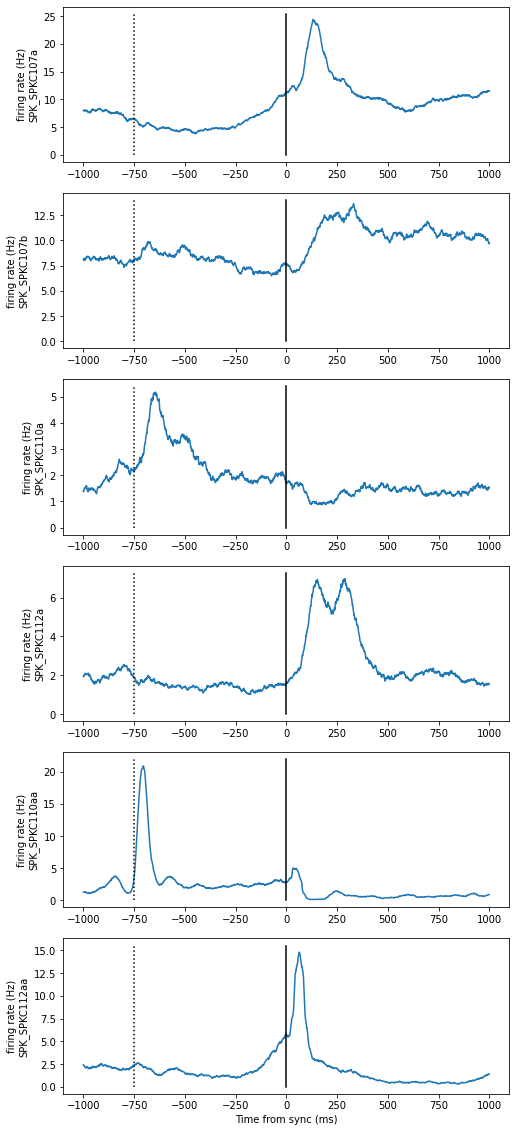

In [26]:
unit_names = unit_meta.ID

fig = plt.figure(figsize=(8, 20))

t_idx = np.arange(-1000, 1000)

for u in range(len(unit_names)):
    ax = fig.add_subplot(len(unit_names), 1, u + 1)
    ax.plot(t_idx, 1000*np.mean(fr_chopped[:, :, u], axis=0))
    
    y = ax.get_ylim()
    new_y = (0, y[1])
    
    ax.plot(np.array([0, 0]), new_y, "k")
    ax.plot(np.array([-750, -750]), new_y, "k:")
    ax.set_ylabel("firing rate (Hz)\n"+unit_names[u])
    
ax.set_xlabel("Time from sync (ms)")


## Let's check out some LFP magnitudes and phases synced to the start of the trial

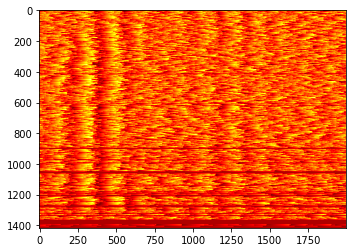

In [29]:
# phase
fig, ax = plt.subplots()
ax.imshow(phs_chopped[1][:, :, 0], cmap="hot")

Text(0, 0.5, 'theta magnitude (st dev)')

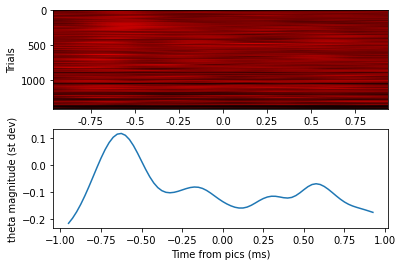

In [59]:
# mag
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(theta_smooth_100ms[:, :, 0], cmap="hot", aspect="auto")
ax.set_xticks(np.arange(8, 75, 10))
ax.set_xticklabels(np.round(mid_times_100ms[np.arange(8, 75, 10)], 3))
ax.set_xlabel("Time from pics (ms)")
ax.set_ylabel("Trials")

ax = fig.add_subplot(2, 1, 2)
ax.plot(mid_times_100ms, np.mean(theta_smooth_100ms[:, :, 0], axis=0))
ax.set_xlabel("Time from pics (ms)")
ax.set_ylabel("theta magnitude (st dev)")


Text(0, 0.5, 'beta magnitude (st dev)')

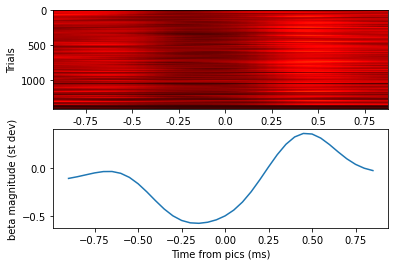

In [60]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(beta_smooth_200ms[:, :, 0], cmap="hot", aspect="auto")
ax.set_xticks(np.arange(3, 35, 5))
ax.set_xticklabels(np.round(mid_times_200ms[np.arange(3, 35, 5)], 3))
ax.set_xlabel("Time from pics (ms)")
ax.set_ylabel("Trials")

ax = fig.add_subplot(2, 1, 2)
ax.plot(mid_times_200ms, np.mean(beta_smooth_200ms[:, :, 0], axis=0))
ax.set_xlabel("Time from pics (ms)")
ax.set_ylabel("beta magnitude (st dev)")

